# بسم الله الرحمن الرحيم

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [3]:
# load dataset

with zipfile.ZipFile('/content/drive/MyDrive/Teeth DataSet.zip' , 'r') as file :
  file.extractall('/content/Teeth Dataset')

In [4]:
d_train = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Teeth Dataset/Teeth_Dataset/Training',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 32,
    image_size = (256 , 256),
    shuffle = True
)

d_test = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Teeth Dataset/Teeth_Dataset/Testing',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 32,
    image_size = (256 , 256),
    shuffle = True
)

d_valid = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Teeth Dataset/Teeth_Dataset/Validation',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 32,
    image_size = (256 , 256),
    shuffle = True
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


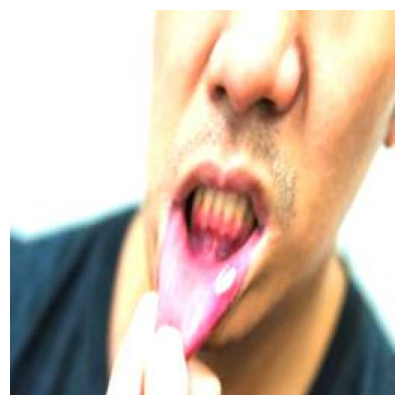

In [5]:
# show sample of data

sample_data = next(iter(d_train))

image = sample_data[0][0]

plt.figure(figsize=(5,5))
plt.imshow(image.numpy().astype('uint8'))
plt.axis('off')
plt.show()


In [6]:
# apply augmentation on training dataset

data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1) ,
    tf.keras.layers.RandomContrast(0.2) ,
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomZoom(0.2)
])

d_train = d_train.map(lambda x , y : (data_augment(x) , y))

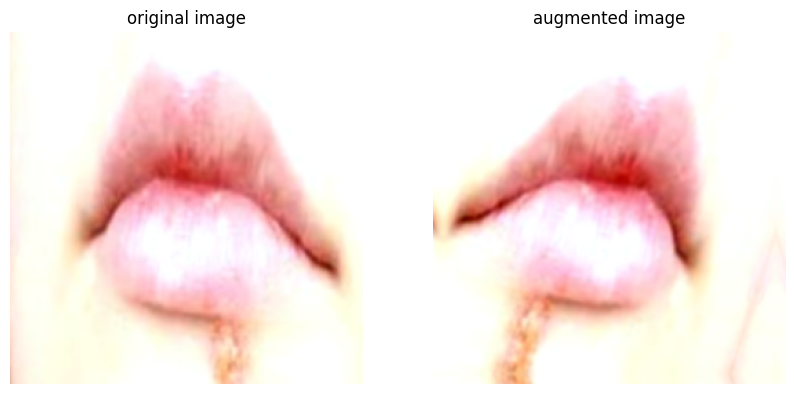

In [7]:
# test the augmentation

images , labels = next(iter(d_train))
augmented_images = data_augment(images)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[0].numpy().astype('uint8'))
plt.title(f"original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented_images[0].numpy().astype('uint8'))
plt.title(f"augmented image")
plt.axis("off")
plt.show()

# use models
**i will use three models:**


1.   MobileNetV2
2.   ResNet50
3.   EfficientNetB3

****
**first i will train as feature extraction , then i will unfreeze some blocks from model to update weights based on my specific dataset, for all models**


In [8]:
# global function

def first_train_model(name , base_model , preprocesse_input , num_classes):
  print(f'training {name}')

  # preprocess of model
  train_prep = d_train.map(lambda x , y : (preprocesse_input(x) , y))
  vald_prep = d_valid.map(lambda x , y : (preprocesse_input(x) , y))
  test_prep = d_test.map(lambda x , y : (preprocesse_input(x) , y))

  # performance optimization
  train_prep = train_prep.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
  vald_prep = vald_prep.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

  # build model
  base_model.trainable = False
  model = tf.keras.Sequential(
      [
          base_model ,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(128 , activation = 'relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(num_classes , activation='softmax')
      ]
  )

  # compile model
  model.compile(
      optimizer = "adam" ,
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  history = model.fit(train_prep , validation_data = vald_prep , epochs = 10)

  # evaluation
  loss , accurecy = model.evaluate(test_prep)

  return model , {
      'name' : name ,
      'loss': loss ,
      'accurecy' : accurecy ,
      'history' : history
  }


In [9]:
# first train of model
results = []
mobile_model , hist1 = first_train_model(
    name='MobileNetv2' ,
    base_model=tf.keras.applications.MobileNetV2(
        weights = 'imagenet',
        include_top = False ,
        input_shape = (256,256,3)
    ) ,
    preprocesse_input= tf.keras.applications.mobilenet_v2.preprocess_input ,
    num_classes = 7
)
results.append(hist1)

/tmp/ipython-input-9-3727459852.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
training MobileNetv2
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.4067 - loss: 1.5610 - val_accuracy: 0.7023 - val_loss: 0.8655
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7070 - loss: 0.8069 - val_accuracy: 0.7296 - val_loss: 0.7132
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7929 - loss: 0.5893 - val_accuracy: 0.8239 - val_loss: 0.4957
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8602 - loss: 0.4089 - val_accuracy: 0.8210 - val_loss: 0.5092
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9141 - loss: 0.2951 - val_accuracy: 0.8385 - val_loss: 0.4372
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9308 - loss: 0.2465 - val_accuracy: 0.8346 - val_loss: 0.4177
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9470 - loss: 0.1893 - val_accuracy: 0.8833 - val_loss: 0.3190
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4

In [10]:
resnet_model , hist2 = first_train_model(
    name='ResNet50' ,
    base_model=tf.keras.applications.ResNet50(
        weights = 'imagenet',
        include_top = False ,
        input_shape = (256,256,3)
    ) ,
    preprocesse_input= tf.keras.applications.resnet50.preprocess_input ,
    num_classes = 7
)
results.append(hist2)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
training ResNet50
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 94s 256ms/step - accuracy: 0.4196 - loss: 1.6418 - val_accuracy: 0.7558 - val_loss: 0.7356
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.7324 - loss: 0.7633 - val_accuracy: 0.8220 - val_loss: 0.5165
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8271 - loss: 0.5329 - val_accuracy: 0.8716 - val_loss: 0.4120
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.8692 - loss: 0.4022 - val_accuracy: 0.8638 - val_loss: 0.3858
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9185 - loss: 0.2840 - val_accuracy: 0.9232 - val_loss: 0.2484
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9304 - loss: 0.2197 - val_accuracy: 0.9066 - val_loss: 0.2647
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9536 - loss: 0.1649 - val_accuracy: 0.9193 - val_loss: 0.2538
Epoch 8/10
97/97 ━━━━━━━━━━━

In [11]:
effit_model , hist3 = first_train_model(
    name='EfficientNetB3' ,
    base_model=tf.keras.applications.EfficientNetB3(
        weights = 'imagenet',
        include_top = False ,
        input_shape = (256,256,3)
    ) ,
    preprocesse_input= tf.keras.applications.efficientnet.preprocess_input ,
    num_classes = 7
)
results.append(hist3)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
training EfficientNetB3
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 528ms/step - accuracy: 0.4748 - loss: 1.4285 - val_accuracy: 0.7364 - val_loss: 0.7483
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7474 - loss: 0.7319 - val_accuracy: 0.8541 - val_loss: 0.4771
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8486 - loss: 0.4785 - val_accuracy: 0.8745 - val_loss: 0.3986
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.8793 - loss: 0.3850 - val_accuracy: 0.8949 - val_loss: 0.3220
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9181 - loss: 0.2830 - val_accuracy: 0.9163 - val_loss: 0.2666
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9364 - loss: 0.2185 - val_accuracy: 0.9037 - val_loss: 0.2609
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9542 - loss: 0.1686 - val_accuracy: 0.9261 - val_loss: 0.2283
Epoch 8/10
97/97 ━━━━

In [12]:
import pandas as pd
df = pd.DataFrame(results)
df

,name,loss,accurecy,history
0,MobileNetv2,0.240745,0.914397,<keras.src.callbacks.history.History object at...
1,ResNet50,0.138080,0.959144,<keras.src.callbacks.history.History object at...
2,EfficientNetB3,0.187418,0.930934,<keras.src.callbacks.history.History object at...


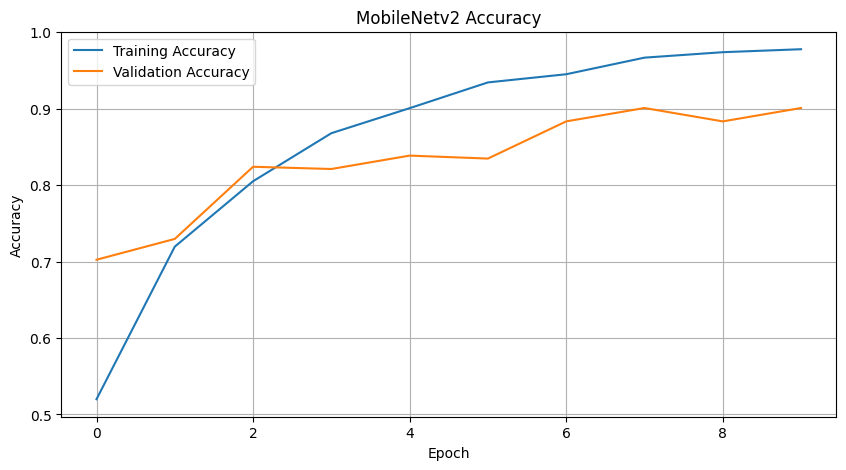

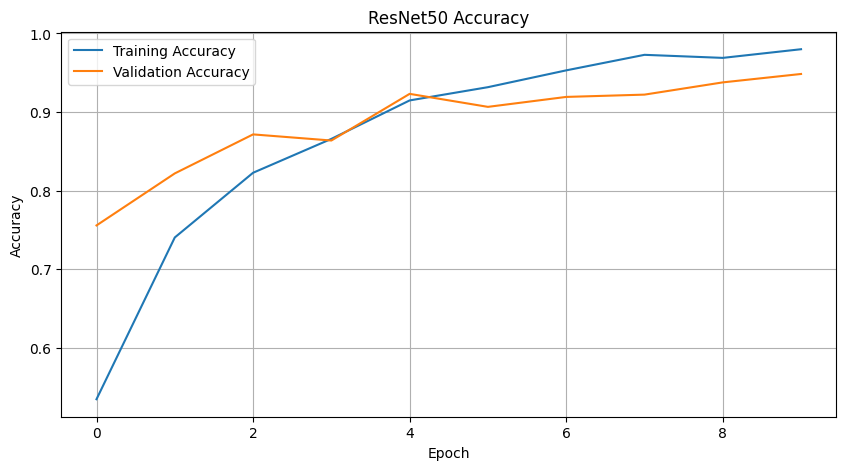

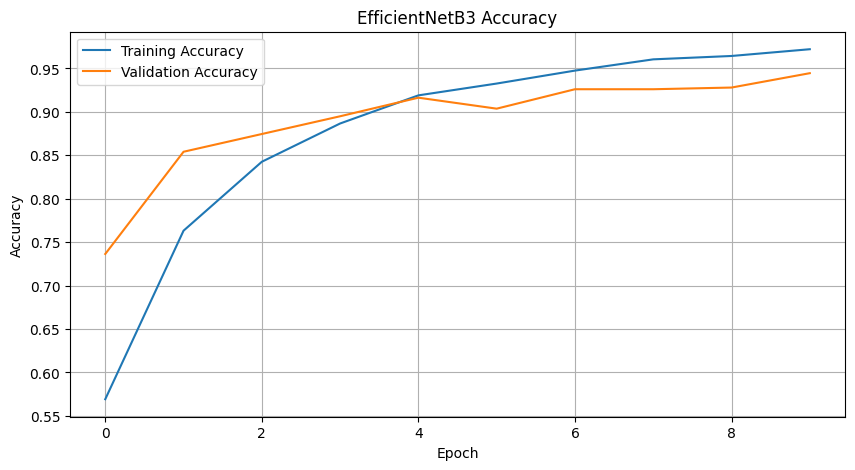

In [13]:
def plot_accuracy(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

for index, row in df.iterrows():
    plot_accuracy(row['history'], row['name'])

In [14]:
# best model before tuning
best_model_befortune = max(results, key=lambda x: x['accurecy'])["name"]
best_model_befortune

'ResNet50'

In [15]:
# now i will tune every model to optemize the performance

def second_train_model(name , base_model , preprocesse_input , num_classes):
  print(f'training {name}')

  # preprocess of model
  train_prep = d_train.map(lambda x , y : (preprocesse_input(x) , y))
  vald_prep = d_valid.map(lambda x , y : (preprocesse_input(x) , y))
  test_prep = d_test.map(lambda x , y : (preprocesse_input(x) , y))

  # performance optimization
  train_prep = train_prep.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
  vald_prep = vald_prep.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

  # build model
  base_model.trainable = True

  # choose just last 10 layers
  for layer in base_model.layers[:-10]:
    layer.trainable = False

  model = tf.keras.Sequential(
      [
          base_model ,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(128 , activation = 'relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(num_classes , activation='softmax')
      ]
  )

  # compile model
  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) ,
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  history = model.fit(train_prep , validation_data = vald_prep , epochs = 10)

  # evaluation
  loss , accurecy = model.evaluate(test_prep)

  return model , {
      'name' : name ,
      'loss': loss ,
      'accurecy' : accurecy ,
      'history' : history
  }

In [16]:
mobile_model2 , mobilenet_hist = second_train_model(
    name='MobileNetv2' ,
    base_model=tf.keras.applications.MobileNetV2(
        weights = 'imagenet',
        include_top = False ,
        input_shape = (256,256,3)
    ),
    preprocesse_input= tf.keras.applications.mobilenet_v2.preprocess_input ,
    num_classes = 7
)

/tmp/ipython-input-16-598377648.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=tf.keras.applications.MobileNetV2(


training MobileNetv2
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.1687 - loss: 2.1180 - val_accuracy: 0.2257 - val_loss: 1.8653
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3335 - loss: 1.7039 - val_accuracy: 0.3220 - val_loss: 1.7033
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4519 - loss: 1.4919 - val_accuracy: 0.3570 - val_loss: 1.6485
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5142 - loss: 1.3462 - val_accuracy: 0.3881 - val_loss: 1.5933
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5922 - loss: 1.2103 - val_accuracy: 0.4251 - val_loss: 1.5149
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6408 - loss: 1.0991 - val_accuracy: 0.4572 - val_loss: 1.4441
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6858 - loss: 1.0093 - val_accuracy: 0.4776 - val_loss: 1.3673
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7031 - loss: 0.9491 - v

In [17]:
resnet_model , resnet_hist = second_train_model(
    name='ResNet50' ,
    base_model=tf.keras.applications.ResNet50(
        weights = 'imagenet',
        include_top = False ,
        input_shape = (256,256,3)
        ),
    preprocesse_input= tf.keras.applications.resnet50.preprocess_input ,
    num_classes = 7
)

training ResNet50
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 96s 265ms/step - accuracy: 0.2018 - loss: 2.1733 - val_accuracy: 0.3823 - val_loss: 1.6641
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.3858 - loss: 1.6271 - val_accuracy: 0.5292 - val_loss: 1.3262
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5379 - loss: 1.3065 - val_accuracy: 0.6021 - val_loss: 1.1093
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.6221 - loss: 1.1092 - val_accuracy: 0.6595 - val_loss: 0.9619
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.6914 - loss: 0.9470 - val_accuracy: 0.7160 - val_loss: 0.8453
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.7389 - loss: 0.8155 - val_accuracy: 0.7471 - val_loss: 0.7459
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.8043 - loss: 0.6899 - val_accuracy: 0.7831 - val_loss: 0.6681
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.8374 - loss:

In [18]:
effit_model , effit_hist = second_train_model(
    name='EfficientNetB3' ,
    base_model=tf.keras.applications.EfficientNetB3(
        weights = 'imagenet',
        include_top = False ,
        input_shape = (256,256,3)
    ),
    preprocesse_input= tf.keras.applications.efficientnet.preprocess_input ,
    num_classes = 7
)

training EfficientNetB3
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 530ms/step - accuracy: 0.1556 - loss: 1.9962 - val_accuracy: 0.2383 - val_loss: 1.8637
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.2585 - loss: 1.8296 - val_accuracy: 0.3940 - val_loss: 1.6998
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.3862 - loss: 1.6966 - val_accuracy: 0.4825 - val_loss: 1.5669
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.4563 - loss: 1.5667 - val_accuracy: 0.5350 - val_loss: 1.4533
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.5045 - loss: 1.4650 - val_accuracy: 0.5642 - val_loss: 1.3588
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.5318 - loss: 1.4029 - val_accuracy: 0.5875 - val_loss: 1.2735
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.5605 - loss: 1.3114 - val_accuracy: 0.5992 - val_loss: 1.2019
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.5953 

In [19]:
df2 = pd.DataFrame([mobilenet_hist , resnet_hist , effit_hist])
df2

,name,loss,accurecy,history
0,MobileNetv2,1.097797,0.594358,<keras.src.callbacks.history.History object at...
1,ResNet50,0.448728,0.872568,<keras.src.callbacks.history.History object at...
2,EfficientNetB3,0.998210,0.682879,<keras.src.callbacks.history.History object at...


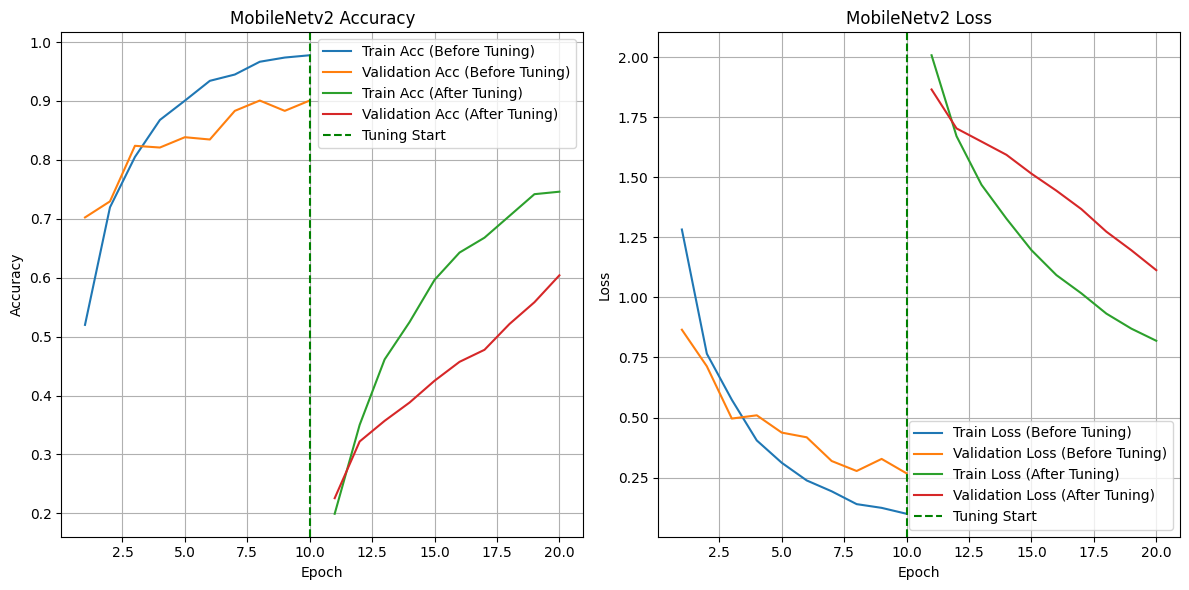

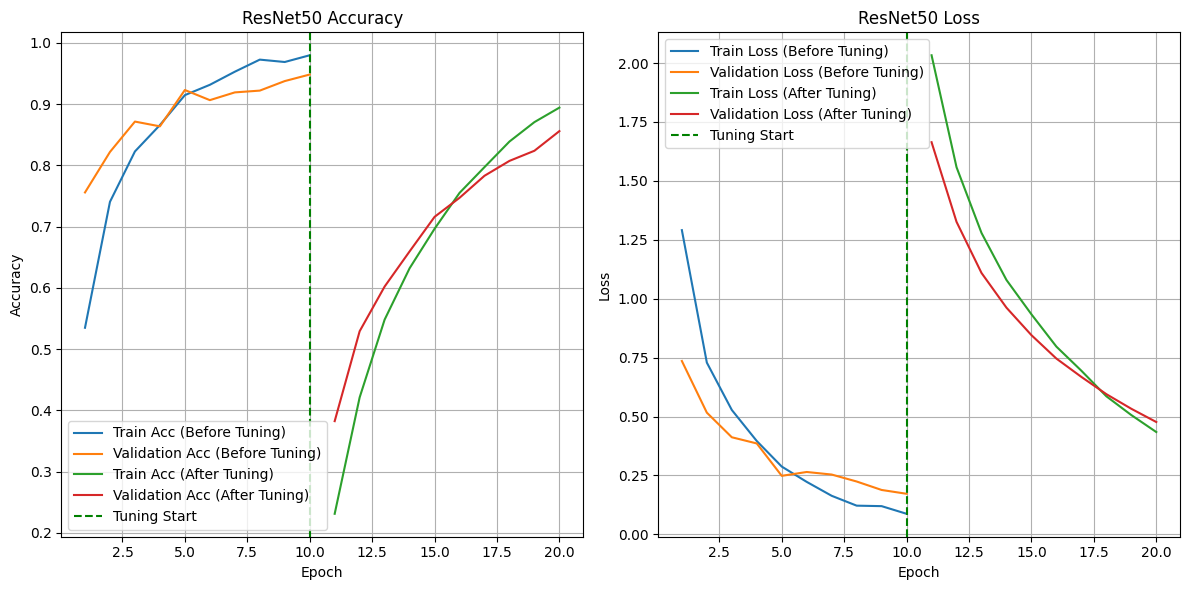

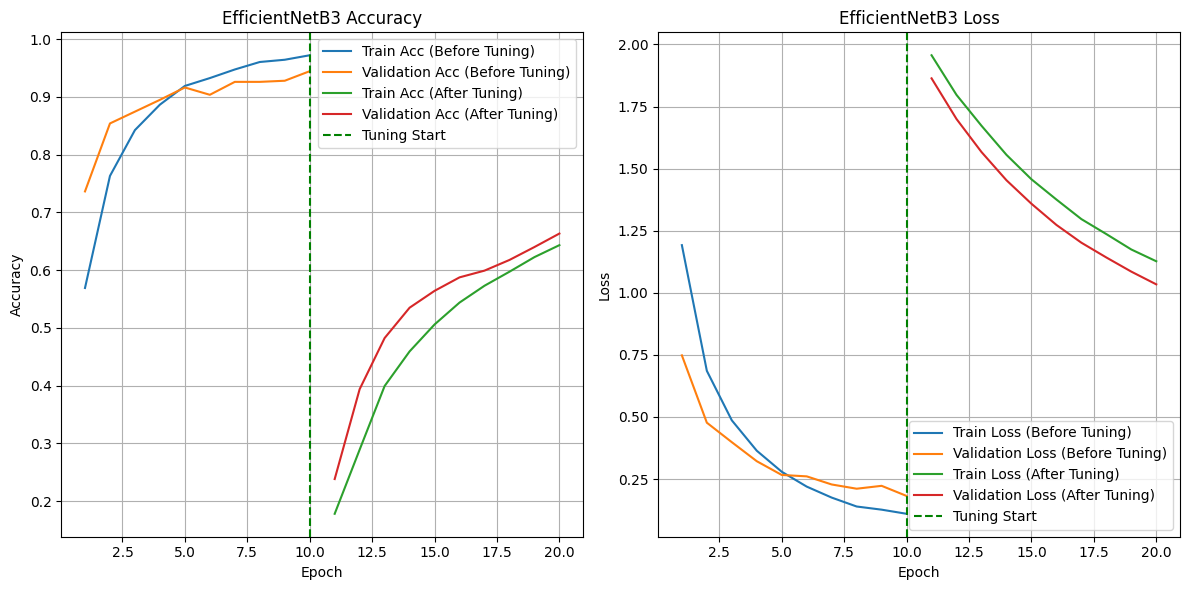

In [20]:
def plot_history_comparison(history1, history2, model_name):
    epochs1 = len(history1.history['accuracy'])
    epochs2 = len(history2.history['accuracy'])
    total_epochs = epochs1 + epochs2

    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs1 + 1), history1.history['accuracy'], label='Train Acc (Before Tuning)')
    plt.plot(range(1, epochs1 + 1), history1.history['val_accuracy'], label='Validation Acc (Before Tuning)')
    plt.plot(range(epochs1 + 1, total_epochs + 1), history2.history['accuracy'], label='Train Acc (After Tuning)')
    plt.plot(range(epochs1 + 1, total_epochs + 1), history2.history['val_accuracy'], label='Validation Acc (After Tuning)')
    plt.axvline(x=epochs1, color='g', linestyle='--', label='Tuning Start')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs1 + 1), history1.history['loss'], label='Train Loss (Before Tuning)')
    plt.plot(range(1, epochs1 + 1), history1.history['val_loss'], label='Validation Loss (Before Tuning)')
    plt.plot(range(epochs1 + 1, total_epochs + 1), history2.history['loss'], label='Train Loss (After Tuning)')
    plt.plot(range(epochs1 + 1, total_epochs + 1), history2.history['val_loss'], label='Validation Loss (After Tuning)')
    plt.axvline(x=epochs1, color='g', linestyle='--', label='Tuning Start')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Iterate through the results and plot for each model
for index, row in df.iterrows():
    model_name = row['name']
    history_before = row['history']
    # Find the corresponding history after tuning from df2
    history_after = df2[df2['name'] == model_name]['history'].iloc[0]
    plot_history_comparison(history_before, history_after, model_name)

In [21]:
df['Tuning'] = 'Before Tuning'
df2['Tuning'] = 'After Tuning'

all_results = pd.concat([df, df2], ignore_index=True)
display(all_results)

,name,loss,accurecy,history,Tuning
0,MobileNetv2,0.240745,0.914397,<keras.src.callbacks.history.History object at...,Before Tuning
1,ResNet50,0.138080,0.959144,<keras.src.callbacks.history.History object at...,Before Tuning
2,EfficientNetB3,0.187418,0.930934,<keras.src.callbacks.history.History object at...,Before Tuning
3,MobileNetv2,1.097797,0.594358,<keras.src.callbacks.history.History object at...,After Tuning
4,ResNet50,0.448728,0.872568,<keras.src.callbacks.history.History object at...,After Tuning
5,EfficientNetB3,0.998210,0.682879,<keras.src.callbacks.history.History object at...,After Tuning


In [22]:
best_model_overall = all_results.loc[all_results['accurecy'].idxmax()]

print("Best Model Overall:")
print(best_model_overall)

Best Model Overall:
name                                                 ResNet50
loss                                                  0.13808
accurecy                                             0.959144
history     <keras.src.callbacks.history.History object at...
Tuning                                          Before Tuning
Name: 1, dtype: object


In [25]:
# Save the best model for deployment

# Based on the previous analysis, the best model overall was ResNet50 from the 'Before Tuning' stage.

best_model_for_deployment = resnet_model

best_model_for_deployment.save('model.keras')

print("Best model (ResNet50 before tuning) saved successfully for deployment.")

Best model (ResNet50 before tuning) saved successfully for deployment.
